In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

/home/qazw5741/miniconda3/envs/SAM/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [3]:
from pycocotools.coco import COCO
import os.path as osp
db = COCO(osp.join('/database/changhee', 'MuCo', 'data', 'MuCo-3DHP.json'))


loading annotations into memory...


In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/qazw5741/segment-anything/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [ ]:
path_img="/database/changhee/MuCo/data"
for sub_n,iid in enumerate(db.imgs.keys()):
    aids = db.getAnnIds([iid])
    img = db.imgs[iid]
    imgname = img['file_name']
    image=cv2.imread(osp.join(path_img,imgname))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    joints=[]
    for aid in aids:
        ann = db.anns[aid]
        #print(ann)
        joint_img = np.array(ann['keypoints_img'], dtype=np.float32).reshape(-1, 2)
        joints.append(joint_img)
    if sub_n==2:
        break

{'id': 0, 'image_id': 0, 'keypoints_img': [[1134.015, 296.914], [1125.355, 388.97], [1074.01, 394.962], [1010.665, 452.283], [978.605, 454.95], [1171.66, 423.982], [1181.56, 542.925], [1126.93, 617.34], [1003.365, 508.965], [976.49, 659.945], [982.815, 738.075], [1079.115, 550.965], [1010.48, 660.935], [999.945, 662.34], [1041.24, 529.965], [1079.989, 470.112], [1131.435, 359.685], [972.865, 445.75], [1112.315, 642.335], [974.185, 779.125], [973.745, 681.165]], 'keypoints_cam': [[1756.38, -576.546, 2075.12], [1787.04, -331.786, 2140.59], [1736.41, -333.098, 2265.95], [1741.26, -180.095, 2554.06], [1537.69, -161.124, 2406.5], [1835.78, -221.686, 2047.39], [1864.03, 103.338, 2048.72], [1715.21, 306.878, 2049.39], [1645.11, 15.279, 2451.413], [1656.49, 537.948, 2603.93], [1815.78, 875.65, 2816.95], [1795.05, 142.542, 2309.587], [1808.25, 551.65, 2653.27], [2016.06, 633.673, 3020.53], [1720.08, 78.911, 2380.5], [1751.983, -107.352, 2261.286], [1773.9, -408.41, 2104.39], [1477.87, -185.474,

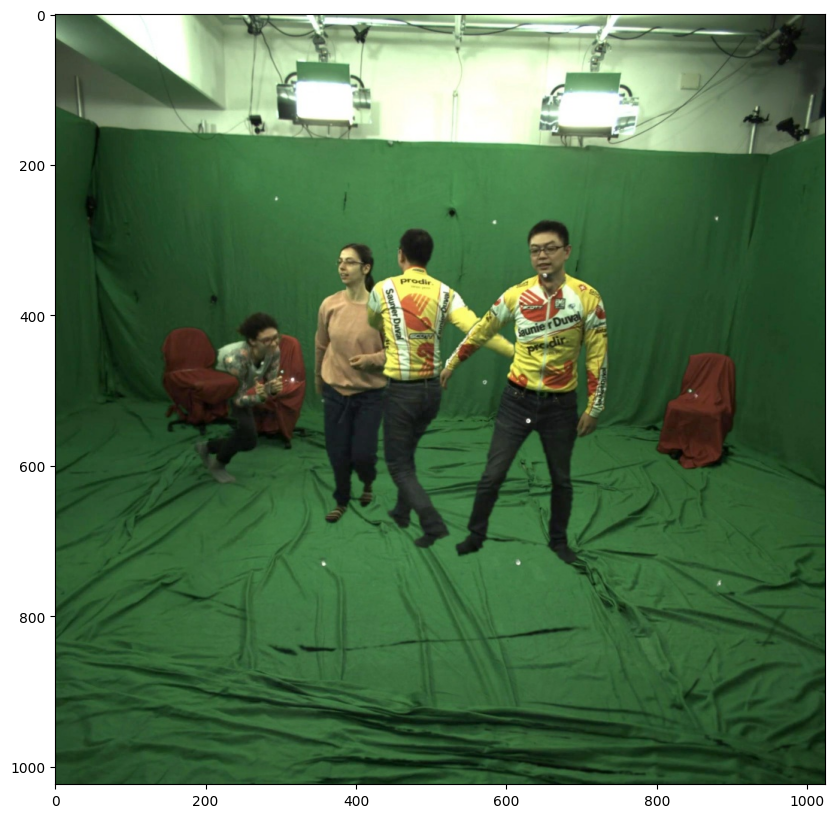

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.savefig("./assets/MuCo_input.jpg",bbox_inches='tight', pad_inches=0)
plt.show()

In [30]:
predictor.set_image(image)

In [31]:
joints[0].shape

(21, 2)

In [32]:
j_valid=np.ones((21,1))
new_j=np.concatenate((joints[0],j_valid),axis=1)

In [33]:
input_point = new_j[:,:2]
input_label = new_j[:,2]

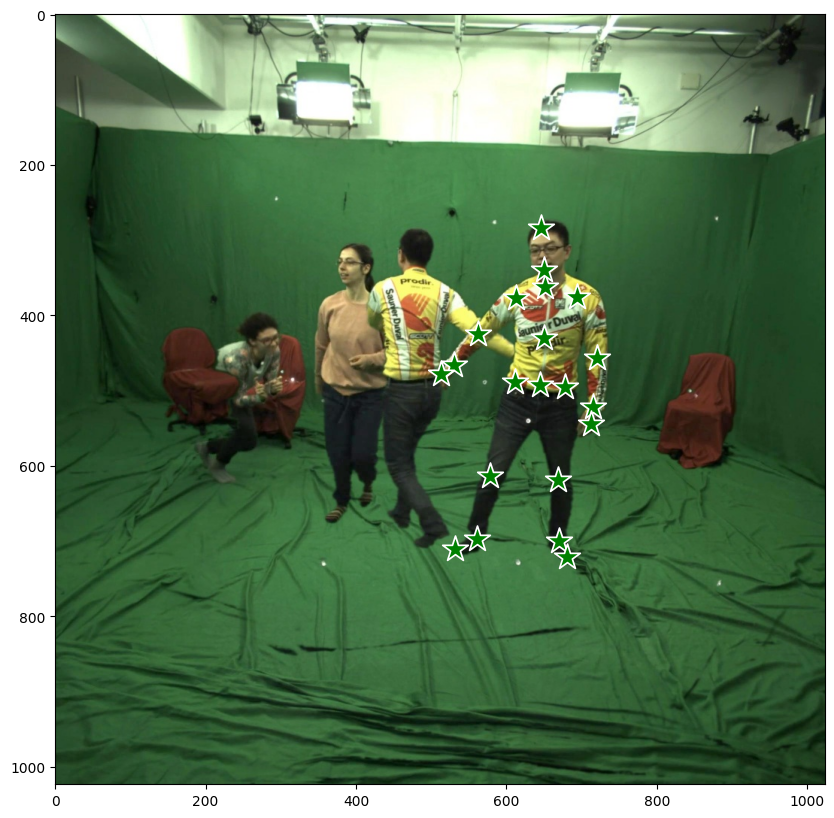

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [35]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [36]:
scores

array([0.71918696, 0.9376948 , 0.9482242 ], dtype=float32)

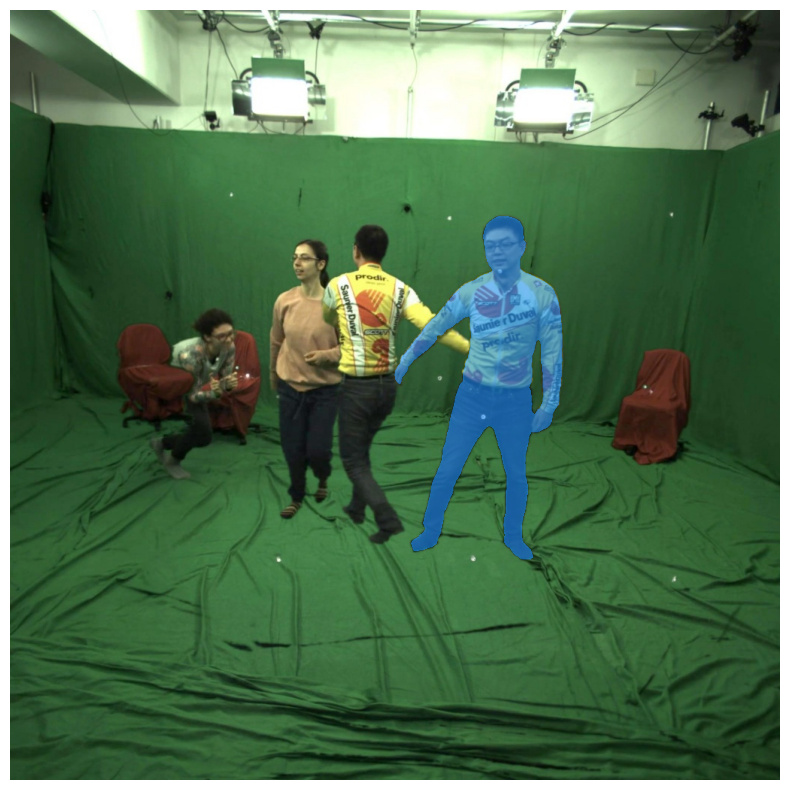

In [37]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks[2], plt.gca())
#show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 